# Decision Tree Regressor from Scratch

This notebook implements a **Decision Tree Regressor** from scratch using only NumPy. We build the complete implementation step-by-step:

1. **Tree Node Classes** - LeafNode and InternalDecisionNode for tree structure
2. **Best Binary Split Selection** - Finding optimal splits using sum of squared errors
3. **Greedy Tree Training** - Recursive algorithm to build the tree
4. **Decision Tree Regressor Class** - sklearn-like interface for easy usage

---

## 1. Import Required Libraries

Import NumPy for numerical operations and matplotlib for visualization.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

---

## 2. Tree Node Classes

A decision tree consists of two types of nodes:

### LeafNode
A terminal node that makes **constant predictions**. For regression, it predicts the mean of all training examples that reach this leaf.

### InternalDecisionNode  
A decision node that splits data based on a **feature threshold**. Examples with feature value less than the threshold go to the left child, others go to the right child.

Both classes implement a `predict()` method that can make predictions on new data.

In [2]:
class LeafNode(object):
    
    '''
    Defines a single node within a binary tree that makes constant predictions.

    We assume the objective function is to minimize squared error on the train
    set. This means the optimal thing to do is to predict the mean of all the
    train examples that reach the region defined by this leaf.

    Attributes
    ----------
    x_NF : 2D array, shape (N,F)
        Feature vectors of the N training examples that have reached this node.
    y_N : 1D array, shape (N,)
        Labels of the N training examples that have reached this node.
        This may be a subset of all the training examples.
    '''

    def __init__(self, x_NF, y_N):
        self.x_NF = x_NF
        self.y_N = y_N

    def predict(self, x_TF):
        ''' Make prediction given provided feature array
        
        For a leaf node, all input examples get the same predicted value,
        which is determined by the mean of the training set y values
        that reach this node.

        Args
        ----
        x_TF : 2D numpy array, shape (T, F)

        Returns
        -------
        yhat_T : 1D numpy array, shape (T,)
            Predicted y value for each provided example
        '''
        T = x_TF.shape[0]
        
        # For a leaf, predict the same value for all inputs:
        # the mean of the y-values from the training data that reached this leaf.
        # Use self.y_N to compute this prediction.
        if self.y_N.size == 0:
            # Handle the (unlikely) case of a leaf with no training examples
            prediction_value = 0.0
        else:
            prediction_value = np.mean(self.y_N)
        
        # Create an array of shape (T,) filled with this constant value
        yhat_T = np.full(T, prediction_value, dtype=np.float64)
        return yhat_T


    def __str__(self):
        ''' Pretty print a string representation of this node
        
        Returns
        -------
        s : string
        ''' 
        if self.y_N.size == 0:
             return "Leaf: predict y = 0.000 (empty)"
        return "Leaf: predict y = %.3f" % np.mean(self.y_N)

In [3]:
class InternalDecisionNode(object):

    '''
    Defines a single node used to make yes/no decisions within a binary tree.

    Attributes
    ----------
    x_NF : 2D array, shape (N,F)
        Feature vectors of the N training examples that have reached this node.
    y_N : 1D array, shape (N,)
        Labels of the N training examples that have reached this node.
    feat_id : int
        Which feature this node will split on.
    thresh_val : float
        The value of the threshold used to divide input examples to either the
        left or the right child of this node.
    left_child : instance of InternalDecisionNode or LeafNode class
        Use to make predictions for examples less than this node's threshold.
    right_child : instance of InternalDecisionNode or LeafNode class
        Use to make predictions for examples greater than this node's threshold.
    '''

    def __init__(self, x_NF, y_N, feat_id, thresh_val, left_child, right_child):
        self.x_NF = x_NF
        self.y_N = y_N
        self.feat_id = feat_id
        self.thresh_val = thresh_val
        self.left_child = left_child
        self.right_child = right_child


    def predict(self, x_TF):
        ''' Make prediction given provided feature array

        For an internal node, we assign each input example to either our
        left or right child to get its prediction.
        We then aggregate the results into one array to return.

        Args
        ----
        x_TF : 2D numpy array, shape (T, F)

        Returns
        -------
        yhat_T : 1D numpy array, shape (T,)
        '''
        T, F = x_TF.shape

        # Determine which of the input T examples belong to the 
        # left child and which belong to the right
        # Use this node's "feat_id" and "thresh_val" attributes
        feature_col_T = x_TF[:, self.feat_id]
        
        # Create boolean masks to identify which rows go left vs. right
        left_mask_T = feature_col_T < self.thresh_val
        right_mask_T = feature_col_T >= self.thresh_val 

        # Initialize an output array
        yhat_T = np.empty(T, dtype=np.float64)

        # Ask the left child for its predictions (call 'predict')
        if np.any(left_mask_T): # Only make recursive call if there are examples
            yhat_left = self.left_child.predict(x_TF[left_mask_T])
            yhat_T[left_mask_T] = yhat_left

        # Ask the right child for its predictions (call 'predict')
        if np.any(right_mask_T): # Only make recursive call if there are examples
            yhat_right = self.right_child.predict(x_TF[right_mask_T])
            yhat_T[right_mask_T] = yhat_right
        
        return yhat_T

    def __str__(self):
        ''' Pretty print a string representation of this node
        
        Returns
        -------
        s : string
        '''
        left_str = self.left_child.__str__()
        right_str = self.right_child.__str__()
        lines = [
            "Decision: X[%d] < %.3f?" % (self.feat_id, self.thresh_val),
            "  Y: " + left_str.replace("\n", "\n    "),
            "  N: " + right_str.replace("\n", "\n    "),
            ]
        return '\n'.join(lines)

### Testing the Node Classes

Let's verify that our node classes work correctly by creating a simple 3-node tree and testing predictions.

In [4]:
# Create a simple dataset
N = 6
F = 1
x_NF = np.linspace(-5, 5, N).reshape((N,F))
y_N = np.hstack([np.linspace(0, 1, N//2), np.linspace(-1, 0, N//2)])

print("Features x_NF:")
print(x_NF.flatten())
print("\nLabels y_N:")
print(y_N)

# Create a manual tree with threshold at 0
feat_id = 0
thresh_val = 0.0
left_mask_N = x_NF[:, feat_id] < thresh_val
right_mask_N = np.logical_not(left_mask_N)

# Create leaf nodes
left_leaf = LeafNode(x_NF[left_mask_N], y_N[left_mask_N])
right_leaf = LeafNode(x_NF[right_mask_N], y_N[right_mask_N])

# Create root internal node
root = InternalDecisionNode(
    x_NF, y_N, feat_id, thresh_val, left_leaf, right_leaf)

print("\n--- Tree Structure ---")
print(root)

print("\n--- Predictions ---")
yhat_N = root.predict(x_NF)
print("Predictions:", np.round(yhat_N, 4))
print("Expected:    [0.5 0.5 0.5 -0.5 -0.5 -0.5]")

Features x_NF:
[-5. -3. -1.  1.  3.  5.]

Labels y_N:
[ 0.   0.5  1.  -1.  -0.5  0. ]

--- Tree Structure ---
Decision: X[0] < 0.000?
  Y: Leaf: predict y = 0.500
  N: Leaf: predict y = -0.500

--- Predictions ---
Predictions: [ 0.5  0.5  0.5 -0.5 -0.5 -0.5]
Expected:    [0.5 0.5 0.5 -0.5 -0.5 -0.5]


---

## 3. Best Binary Split Selection

The `select_best_binary_split` function finds the optimal way to split data at a node:

- **Objective**: Minimize the sum of squared errors (SSE) in the resulting child nodes
- **Method**: For each feature, evaluate all possible thresholds between consecutive unique values
- **Constraints**: Respects `MIN_SAMPLES_LEAF` to ensure leaves have sufficient samples

The function returns:
- Best feature index and threshold value
- Data partitioned into left and right subsets

In [5]:
def select_best_binary_split(x_NF, y_N, MIN_SAMPLES_LEAF=1):
    ''' Determine best single feature binary split for provided dataset

    Args
    ----
    x_NF : 2D array, shape (N,F) = (n_examples, n_features)
        Training data features at current node we wish to find a split for.
    y_N : 1D array, shape (N,) = (n_examples,)
        Training labels at current node.
    min_samples_leaf : int
        Minimum number of samples allowed at any leaf.

    Returns
    -------
    feat_id : int or None, one of {0, 1, 2, .... F-1}
        Indicates which feature in provided x array is used for best split.
        If None, a binary split that improves the cost is not possible.
    thresh_val : float or None
        Value of x[feat_id] at which we threshold.
        If None, a binary split that improves the cost is not possible.
    x_LF : 2D array, shape (L, F)
        Training data features assigned to left child using best split.
    y_L : 1D array, shape (L,)
        Training labels assigned to left child using best split.
    x_RF : 2D array, shape (R, F)
        Training data features assigned to right child using best split.
    y_R : 1D array, shape (R,)
        Training labels assigned to right child using best split.
    '''
    N, F = x_NF.shape

    # Allocate space to store the cost and threshold of each feat's best split
    cost_F = np.inf * np.ones(F)
    thresh_val_F = np.zeros(F)

    for f in range(F):

        # Compute all possible x threshold values for current feature
        # possib_xthresh_V : 1D array of size V
        #    Each entry is a float
        #    Entries are in sorted order from smallest to largest
        #    Represents one possible distinct threshold for provided N examples
        xunique_U = np.unique(x_NF[:,f])
        
        if xunique_U.size <= 1:
            # If all the x values for this feature are same, we can't split.
            cost_F[f] = np.inf
            continue
            
        possib_xthresh_V = 0.5 * (xunique_U[:-1] + xunique_U[1:])
        V = possib_xthresh_V.size
        
        if MIN_SAMPLES_LEAF > 0:
            # Prune thresholds that would violate MIN_SAMPLES_LEAF
            # We find the indices of sorted unique values
            sorted_x_indices = np.searchsorted(xunique_U, x_NF[:, f])
            
            valid_thresh_mask = np.ones(V, dtype=bool)
            for v, thresh in enumerate(possib_xthresh_V):
                # Find how many samples are strictly less than the *next* unique value
                # This corresponds to how many samples are < thresh

                left_count = np.sum(x_NF[:, f] < thresh)
                right_count = N - left_count
                
                if left_count < MIN_SAMPLES_LEAF or right_count < MIN_SAMPLES_LEAF:
                    valid_thresh_mask[v] = False
            
            possib_xthresh_V = possib_xthresh_V[valid_thresh_mask]
            V = possib_xthresh_V.size

        if V == 0:
            # Not possible to split on this feature
            cost_F[f] = np.inf
            continue

        # Compute total cost at each possible threshold
        left_cost_V = np.empty(V)
        right_cost_V = np.empty(V)
        left_yhat_V = np.empty(V)
        right_yhat_V = np.empty(V)

        for v in range(V):
            thresh = possib_xthresh_V[v]
            
            # Identify samples for left and right children
            left_mask = x_NF[:, f] < thresh
            right_mask = ~left_mask # All other samples
            
            y_L = y_N[left_mask]
            y_R = y_N[right_mask]

            # Calculate cost for left child
            # Cost is sum of squared errors from the mean prediction
            if y_L.size == 0:
                # This case should be prevented by MIN_SAMPLES_LEAF >= 1
                left_yhat_V[v] = 0.0
                left_cost_V[v] = 0.0
            else:
                left_yhat_V[v] = np.mean(y_L)
                left_cost_V[v] = np.sum(np.square(y_L - left_yhat_V[v]))

            # Calculate cost for right child
            if y_R.size == 0:
                right_yhat_V[v] = 0.0
                right_cost_V[v] = 0.0
            else:
                right_yhat_V[v] = np.mean(y_R)
                right_cost_V[v] = np.sum(np.square(y_R - right_yhat_V[v]))

        total_cost_V = left_cost_V + right_cost_V

        # Check if there is any split that improves our cost or predictions.
        # If not, all splits will have same cost and we should just not split.
        if total_cost_V.size == 0:
            # No valid splits found
            cost_F[f] = np.inf
            continue
            
        costs_all_the_same = np.allclose(total_cost_V, total_cost_V[0])
        # Check if, for every split, the prediction is the same on left/right
        yhat_all_the_same = np.allclose(left_yhat_V, right_yhat_V)
        
        if costs_all_the_same and yhat_all_the_same:
            # This happens when all y values are the same.
            # Splitting gives no benefit.
            cost_F[f] = np.inf
            continue
        
        # Pick out the split candidate that has best cost
        chosen_v_id = np.argmin(total_cost_V)
        cost_F[f] = total_cost_V[chosen_v_id]
        thresh_val_F[f] = possib_xthresh_V[chosen_v_id]

    # Determine single best feature to use
    best_feat_id = np.argmin(cost_F)
    best_thresh_val = thresh_val_F[best_feat_id]
    
    if not np.isfinite(cost_F[best_feat_id]):
        # Edge case: not possible to split further, because
        # either all x values the same, or all y values are the same
        return (None, None, None, None, None, None)

    ## Assemble the left and right child datasets
    left_mask_N = x_NF[:, best_feat_id] < best_thresh_val
    right_mask_N = np.logical_not(left_mask_N)
    x_LF, y_L = x_NF[left_mask_N], y_N[left_mask_N]
    x_RF, y_R = x_NF[right_mask_N], y_N[right_mask_N]

    # Verify cost computation
    left_cost = np.sum(np.square(y_L - np.mean(y_L)))
    right_cost = np.sum(np.square(y_R - np.mean(y_R)))
    assert np.allclose(cost_F[best_feat_id], left_cost + right_cost)

    return (best_feat_id, best_thresh_val, x_LF, y_L, x_RF, y_R)

### Testing Best Binary Split

Let's test the split selection with various examples including edge cases.

In [6]:
# Example 1: Simple example with F=1 and sorted features
print("--- Example 1a: Simple example with F=1 and sorted features input ---")
N = 6
F = 1
x_NF = np.asarray([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]).reshape((6, 1))
y_N  = np.asarray([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])
feat_id, thresh_val, _, _, _, _ = select_best_binary_split(x_NF, y_N)
print(f"feat_id: {feat_id}")
print(f"thresh_val: {thresh_val}")
assert feat_id == 0
assert np.allclose(thresh_val, 2.5)
print("Test passed!")

# Example 2: Scrambled order
print("\n--- Example 1b: Same as 1a but just scramble the order of x ---")
x_NF = np.asarray([2.0, 1.0, 0.0, 3.0, 5.0, 4.0]).reshape((6, 1))
y_N  = np.asarray([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])
feat_id, thresh_val, _, _, _, _ = select_best_binary_split(x_NF, y_N)
print(f"feat_id: {feat_id}")
print(f"thresh_val: {thresh_val}")
assert feat_id == 0
assert np.allclose(thresh_val, 2.5)
print("Test passed!")

# Example 3: Multiple features
print("\n--- Example 2: Advanced example with F=13 total features ---")
N = 6
F = 13
prng = np.random.RandomState(0)
x_N1 = np.asarray([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]).reshape((6,1))
x_NF = np.hstack([prng.randn(N, F//2), x_N1, np.zeros((N, F//2))])
y_N  = np.asarray([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])
feat_id, thresh_val, _, _, _, _ = select_best_binary_split(x_NF, y_N)
print(f"feat_id: {feat_id}")
print(f"thresh_val: {thresh_val}")
assert feat_id == 6
assert np.allclose(thresh_val, 2.5)
print("Test passed!")

# Example 4: Edge case - all x same
print("\n--- Example 3: binary split isn't possible (because all x same) ---")
N = 5
F = 1
x_NF = np.asarray([3.0, 3.0, 3.0, 3.0, 3.0]).reshape((5,1))
y_N  = np.asarray([0.0, 0.0, 0.0, 1.0, 1.0])
feat_id, thresh_val, _, _, _, _ = select_best_binary_split(x_NF, y_N)
print(f"feat_id is None: {feat_id is None}")
assert feat_id is None
print("Test passed!")

# Example 5: Edge case - all y same
print("\n--- Example 4: binary split isn't possible (because all y same) ---")
N = 5
F = 3
prng = np.random.RandomState(0)
x_NF = prng.rand(N, F)
y_N  = 1.2345 * np.ones(N)
feat_id, thresh_val, _, _, _, _ = select_best_binary_split(x_NF, y_N)
print(f"feat_id is None: {feat_id is None}")
assert feat_id is None
print("Test passed!")

--- Example 1a: Simple example with F=1 and sorted features input ---
feat_id: 0
thresh_val: 2.5
Test passed!

--- Example 1b: Same as 1a but just scramble the order of x ---
feat_id: 0
thresh_val: 2.5
Test passed!

--- Example 2: Advanced example with F=13 total features ---
feat_id: 6
thresh_val: 2.5
Test passed!

--- Example 3: binary split isn't possible (because all x same) ---
feat_id is None: True
Test passed!

--- Example 4: binary split isn't possible (because all y same) ---
feat_id is None: True
Test passed!


---

## 4. Greedy Tree Training Algorithm

The `train_tree_greedy` function builds the decision tree recursively:

**Base Cases (Stopping Conditions):**
1. Maximum depth reached → return LeafNode
2. Not enough samples to split → return LeafNode
3. No valid split found (all x or y values same) → return LeafNode

**Recursive Case:**
1. Find the best split using `select_best_binary_split`
2. Recursively build left and right subtrees
3. Return an InternalDecisionNode linking the subtrees

In [7]:
def train_tree_greedy(
        x_NF, y_N, depth,
        MAX_DEPTH=10,
        MIN_SAMPLES_INTERNAL=2,
        MIN_SAMPLES_LEAF=1):
    ''' Train a binary decision tree on provided dataset in greedy fashion.

    Args
    ----
    x_NF : 2D array, shape (N,F) = (n_examples, n_features)
        Training data features to use to build the tree.
    y_N : 1D array, shape (N,) = (n_examples,)
        Training labels to use to build the tree.
    depth : int
        Current depth of the tree. Needed to use as a recursive function.
        Should be zero when called by end user.
    MAX_DEPTH : int
        Hyperparameter controlling maximum allowed depth.
        Smaller values might protect against overfitting.
    MIN_SAMPLES_INTERNAL : int
        Controls minimum samples allowed for an InternalDecisionNode.
        Higher values might protect against overfitting.
    MIN_SAMPLES_LEAF : int
        Hyperparameter controlling minimum samples allowed for a leaf node.
        Higher values might protect against overfitting.

    Returns
    -------
    root_node : an instance of LeafNode or InternalDecisionNode
        This node determines the root of the requested tree.
        You can query its attributes `left_child` and `right_child` to get
        other nodes in the tree (if they exist).

    '''
    N, F = x_NF.shape
    
    # Enforce that an internal node must have at least 2x min_samples_leaf
    # to be able to split into two valid leaves
    MIN_SAMPLES_INTERNAL = np.maximum(
        MIN_SAMPLES_INTERNAL, 2 * MIN_SAMPLES_LEAF)
    
    # ---
    # BASE CASES (Stopping Conditions)
    # ---
    # 1. If we've reached max depth, return a leaf
    if depth >= MAX_DEPTH:
        return LeafNode(x_NF, y_N)
    # 2. If we don't have enough samples to split, return a leaf
    elif N < MIN_SAMPLES_INTERNAL:
        return LeafNode(x_NF, y_N)
    else:
        # ---
        # RECURSIVE STEP (Find best split and recurse)
        # ---
        
        # Find the best possible split
        feat_id, thresh_val, x_LF, y_L, x_RF, y_R = select_best_binary_split(
                x_NF, y_N, MIN_SAMPLES_LEAF)

        # 3. If no valid split was found, return a leaf
        if feat_id is None:
            # Case where further split is not possible
            # (e.g., all x values are the same, or all y values are the same)
            return LeafNode(x_NF, y_N)
        else:
            # A valid split was found! Recurse.
            
            # Recursively call train_tree_greedy to build the left child
            left_child = train_tree_greedy(
                x_LF, y_L, depth + 1,
                MAX_DEPTH=MAX_DEPTH,
                MIN_SAMPLES_INTERNAL=MIN_SAMPLES_INTERNAL,
                MIN_SAMPLES_LEAF=MIN_SAMPLES_LEAF)
            
            # Recursively call train_tree_greedy to build the right child
            right_child = train_tree_greedy(
                x_RF, y_R, depth + 1,
                MAX_DEPTH=MAX_DEPTH,
                MIN_SAMPLES_INTERNAL=MIN_SAMPLES_INTERNAL,
                MIN_SAMPLES_LEAF=MIN_SAMPLES_LEAF)
            
            # Create the internal node that links to the new children
            return InternalDecisionNode(
                x_NF, y_N, feat_id, thresh_val, left_child, right_child)

### Testing the Tree Training

In [8]:
# Simple test case
print("--- Testing train_tree_greedy ---")
N = 6
F = 1
x_NF = np.asarray([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]).reshape((6, 1))
y_N  = np.asarray([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])

# Train a tree with max depth 2
root_node = train_tree_greedy(
    x_NF, y_N, depth=0, 
    MAX_DEPTH=2, 
    MIN_SAMPLES_LEAF=1)

print("Trained tree structure:")
print(root_node)

# --- Expected tree structure ---
# Decision: X[0] < 2.500?
#   Y: Leaf: predict y = 0.000
#   N: Leaf: predict y = 1.000
# -------------------------------

print("\nPredictions on training data:")
yhat_N = root_node.predict(x_NF)
print(yhat_N)

expected_yhat_N = np.array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0])
print("\nExpected predictions:")
print(expected_yhat_N)

assert np.allclose(yhat_N, expected_yhat_N)
print("\nTest passed! Your tree is trained and can predict.")

--- Testing train_tree_greedy ---
Trained tree structure:
Decision: X[0] < 2.500?
  Y: Leaf: predict y = 0.000
  N: Leaf: predict y = 1.000

Predictions on training data:
[0. 0. 0. 1. 1. 1.]

Expected predictions:
[0. 0. 0. 1. 1. 1.]

Test passed! Your tree is trained and can predict.


---

## 5. Decision Tree Regressor Class

The `MyDecisionTreeRegressor` class provides an **sklearn-like interface** for our decision tree:

- **`__init__`**: Set hyperparameters (max_depth, min_samples_leaf, min_samples_split)
- **`fit(X, y)`**: Train the tree on data
- **`predict(X)`**: Make predictions on new data
- **`__str__`**: Pretty print the tree structure

In [9]:
class MyDecisionTreeRegressor(object):

    '''
    Prediction model object implementing an sklearn-like interface.

    Allows fitting and predicting from a decision tree.

    Attributes
    ----------
    max_depth
    min_samples_leaf
    min_samples_split

    Attributes available after calling fit
    --------------------------------------
    root_node : Instance of InternalDecisionNode or LeafNode from tree_utils
        Supports predict method.
    '''

    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=1):
        ''' Constructor for our prediction object

        Returns
        -------
        new MyDecisionTreeRegressor object
        '''
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def fit(self, x_NF, y_N):
        ''' Make prediction for each example in provided features array

        Args
        ----
        x_NF : 2D numpy array, shape (n_samples, n_features) = (N, F)
            Features for each training sample.
        y_N : 1D numpy array, shape (n_samples,) = (N,)
            Target outcome values for each training sample.

        Returns
        -------
        None.

        Post Condition
        --------------
        Attribute 'root_node' is set to a valid value.
        '''
        self.root_node = train_tree_greedy(
            x_NF, y_N, depth=0,
            MAX_DEPTH=self.max_depth,
            MIN_SAMPLES_INTERNAL=self.min_samples_split,
            MIN_SAMPLES_LEAF=self.min_samples_leaf)

    def predict(self, x_TF):
        ''' Make prediction for each example in provided features array.

        Args
        ----
        x_TF : 2D numpy array, shape (T, F)

        Returns
        -------
        yhat_T : 1D numpy array, shape (T,)
        '''
        return self.root_node.predict(x_TF)

    def to_string(self):
        return str(self.root_node)

    def __str__(self):
        return self.to_string()

---

## 6. Testing the Implementation

Let's test our `MyDecisionTreeRegressor` with a real example and verify the tree structure.

In [10]:
# Create training data
N = 12

x_tr_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_tr_N1 = x_tr_N.reshape((N,1))  # need an (N,1) shaped array
y_tr_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

# Train a tree with depth 2
tree_predictor = MyDecisionTreeRegressor(
    max_depth=2, min_samples_leaf=1, min_samples_split=2)
tree_predictor.fit(x_tr_N1, y_tr_N)

print("Trained tree structure (max_depth=2):")
print(tree_predictor)

print("\nPredictions on training data:")
print(tree_predictor.predict(x_tr_N1))

Trained tree structure (max_depth=2):
Decision: X[0] < 0.034?
  Y: Decision: X[0] < -0.331?
      Y: Leaf: predict y = 0.500
      N: Leaf: predict y = 0.000
  N: Decision: X[0] < 0.547?
      Y: Leaf: predict y = 1.000
      N: Leaf: predict y = 0.333

Predictions on training data:
[0.5        0.5        0.5        0.5        0.         0.
 1.         1.         1.         0.33333333 0.33333333 0.33333333]


---

## 7. Visualization of Predictions

Visualize the decision tree predictions to see the characteristic **step-function** pattern of decision tree regressors.

Trained tree structure (max_depth=5):
Decision: X[0] < 0.034?
  Y: Decision: X[0] < -0.331?
      Y: Decision: X[0] < -0.900?
          Y: Leaf: predict y = 0.000
          N: Decision: X[0] < -0.714?
              Y: Leaf: predict y = 1.000
              N: Decision: X[0] < -0.490?
                  Y: Leaf: predict y = 0.000
                  N: Leaf: predict y = 1.000
      N: Leaf: predict y = 0.000
  N: Decision: X[0] < 0.547?
      Y: Leaf: predict y = 1.000
      N: Decision: X[0] < 0.885?
          Y: Leaf: predict y = 0.000
          N: Leaf: predict y = 1.000


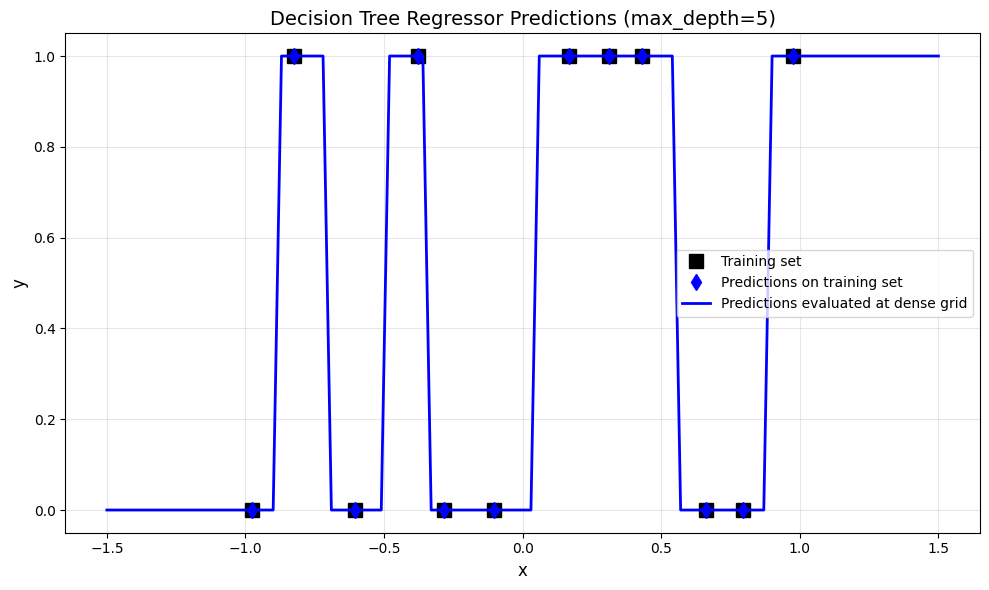

In [11]:
# Train a deeper tree for visualization
tree_predictor = MyDecisionTreeRegressor(
    max_depth=5, min_samples_leaf=1, min_samples_split=2)
tree_predictor.fit(x_tr_N1, y_tr_N)

print("Trained tree structure (max_depth=5):")
print(tree_predictor)

# Create dense grid for smooth visualization
L = 101
x_dense_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_tr_N, y_tr_N, 'ks', markersize=10, label='Training set')
plt.plot(x_tr_N, tree_predictor.predict(x_tr_N1), 'bd', markersize=8,
    label='Predictions on training set')
plt.plot(x_dense_L1, tree_predictor.predict(x_dense_L1), 'b-', linewidth=2,
    label='Predictions evaluated at dense grid')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.title("Decision Tree Regressor Predictions (max_depth=5)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Effect of Tree Depth

Let's visualize how tree depth affects the model's predictions. Deeper trees can fit the training data more closely but may overfit.

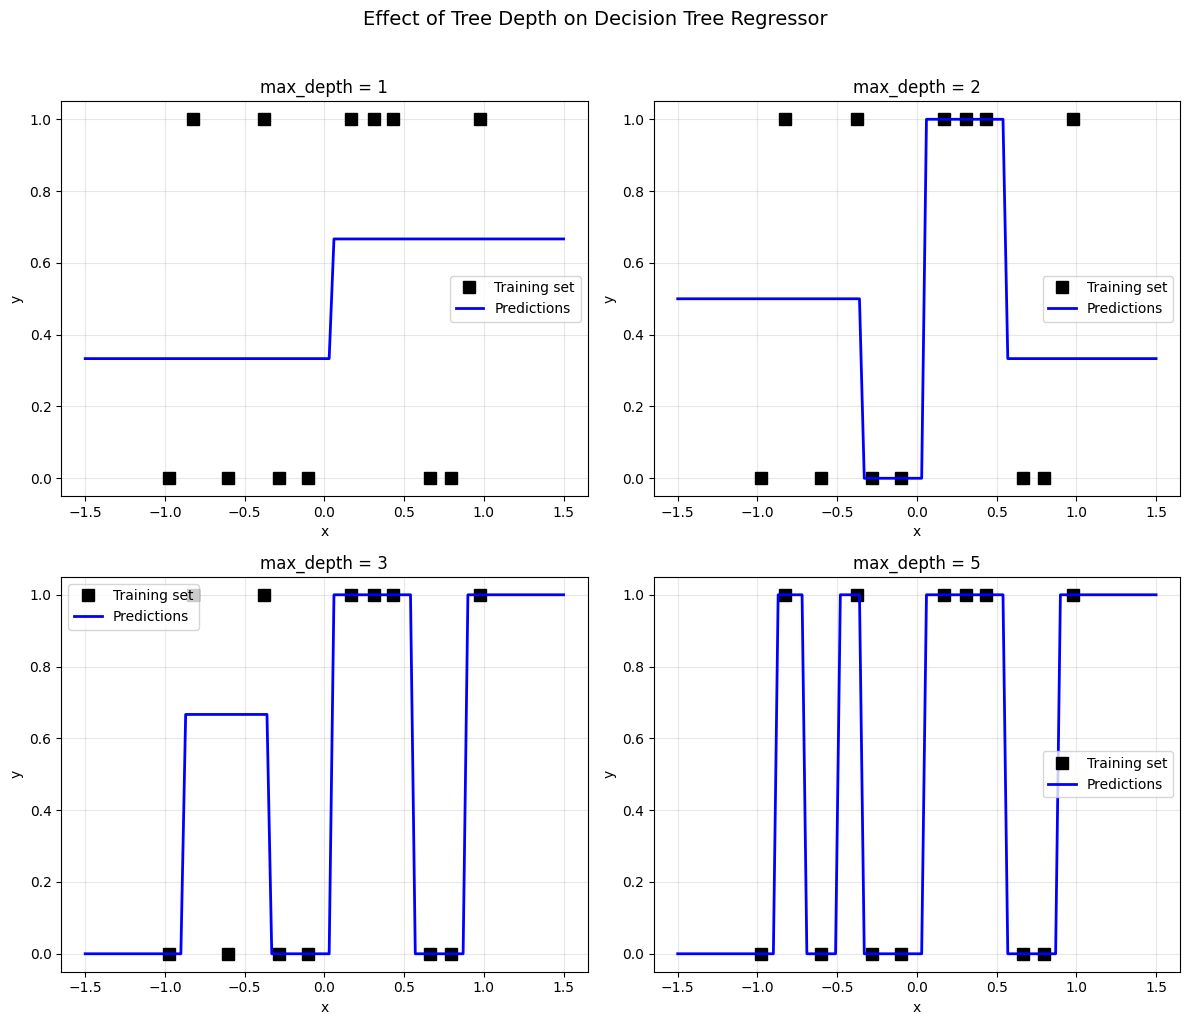

In [12]:
# Compare trees with different depths
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
depths = [1, 2, 3, 5]

for ax, depth in zip(axes.flatten(), depths):
    tree = MyDecisionTreeRegressor(max_depth=depth, min_samples_leaf=1, min_samples_split=2)
    tree.fit(x_tr_N1, y_tr_N)
    
    ax.plot(x_tr_N, y_tr_N, 'ks', markersize=8, label='Training set')
    ax.plot(x_dense_L1, tree.predict(x_dense_L1), 'b-', linewidth=2, label='Predictions')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'max_depth = {depth}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of Tree Depth on Decision Tree Regressor', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Summary

In this notebook, we implemented a **Decision Tree Regressor from scratch** with the following components:

1. **LeafNode** - Terminal nodes that predict the mean of training labels
2. **InternalDecisionNode** - Decision nodes that split based on feature thresholds
3. **select_best_binary_split** - Finds optimal splits minimizing sum of squared errors
4. **train_tree_greedy** - Recursively builds the tree with stopping conditions
5. **MyDecisionTreeRegressor** - Sklearn-like interface for easy usage

**Key Hyperparameters:**
- `max_depth` - Controls tree complexity
- `min_samples_leaf` - Minimum samples required at leaf nodes
- `min_samples_split` - Minimum samples required to split a node

Decision trees are interpretable models that partition the feature space into rectangular regions, each predicting a constant value (the mean of training samples in that region).